#About

The script generates routes that start and end at the same locations for cylists to meet their calorie goals.

**Authors:**

Xiaoyang Guo

Chi Zhang

Shixiong Gao

**Credit to:**

https://github.com/SmartMobilityAlgorithms

#README

To get started, follow the steps below:



1.   In "Global variables" section, change the values of the user input parameters. Provide a Google Maps API key to allow the script to obtain elevation data to calculate calories. A key can be acquired here:
https://developers.google.com/maps/documentation/javascript/get-api-key

2.   Run the entire script from "Import modules" section.

3.   View the animated routes produced by the three bio-inspired algorithms (SA, PSO and FO) in their corresponding sections.



# Import modules

In [ ]:
!apt-get install libspatialindex-c4v5
!pip install osmnx
!pip install tqdm
!pip install ipyleaflet
!pip install plotly
!pip install folium
!pip install keplergl
!pip install matplotlib

#in order to fix ImportError: cannot import name '_png'
!pip install matplotlib==3.1.3

# Keep above lines if using Google Colab
import osmnx as ox
import ipyleaflet as ipyleaflet
import networkx as nx
import plotly.graph_objects as obj
import numpy as np
import json
import requests
from IPython.display import display
import random
import folium as fl
import math
import matplotlib.pyplot as plt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 270 kB of archives.
After this operation, 1,107 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Fetched 270 kB in 1s (466 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_amd64.deb ...
Unpacking libspatialindex4v5:amd64 (1.8.5-5) ...
Selecting previously unselected package libspatialindex-c4v5:amd64.
Preparing to u

     |████████████████████████████████| 5.1MB 13.0MB/s 
     |████████████████████████████████| 7.9MB 10.5MB/s 
  Created wheel for keplergl: filename=keplergl-0.2.2-py2.py3-none-any.whl size=15942748 sha256=517503d3a07936dd2dae5932194b41aa448ff71bdf7167d87ee67e9216e6e705
  Stored in directory: /root/.cache/pip/wheels/0e/78/c4/04ea0dbf6447ad708393751cd6ea453fb682f4c1c734f2247b
Successfully built keplergl
     |████████████████████████████████| 13.1MB 156kB/s 
ERROR: osmnx 0.16.2 has requirement matplotlib>=3.3, but you'll have matplotlib 3.1.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3


# Global variables

In [ ]:
# Constants
number_of_pois_to_travel = 8;
nominatEIM_BASE_URL = 'https://nominatim.openstreetmap.org/search';
MAPS_API_KEY = ''; # Provide a Google Maps API key

# User input
CALORIE_GOAL = 1000; # kcal (calorie)
AVG_SPEED = 20; # mph
WEIGHT = 150; # lbs
BIKE_WEIGHT = 30; # lbs
ORIGIN_ADDR = "1070 Major Mackenzie Dr, Richmond Hill, ON";

# Functions for constructing search space

In [ ]:
#TODO
def getSearchRadius():
  # global AVG_SPEED
  # global WEIGHT
  # global BIKE_WEIGHT
  # global CALORIE_GOAL
  calorie_burning_rate = (AVG_SPEED*(WEIGHT+BIKE_WEIGHT)*0.0053 + 0.0083*(AVG_SPEED**3))*7.2*2
  true_radius = CALORIE_GOAL*AVG_SPEED*1.609*1000/(2*3.14*calorie_burning_rate)
  return true_radius*0.7;

"""
# Partition map evenly into 4 regions
def partitionMap(map_bbox):
  regions = [];
  A = map_bbox[0];
  B = map_bbox[1];
  C = map_bbox[2];
  D = map_bbox[3];
  tags = {
      'amenity': LIST_OF_POI_TAGS
  } 
  regions.append({
      'map': ox.graph_from_bbox(A, abs(A-B)/2+min(A,B), abs(C-D)/2+min(C,D), D, network_type='bike'),
      'amenities': ox.geometries_from_bbox(A, abs(A-B)/2+min(A,B), abs(C-D)/2+min(C,D), D, tags)
  });
  regions.append({
      'map': ox.graph_from_bbox(abs(A-B)/2+min(A,B), B, abs(C-D)/2+min(C,D), D,  network_type='bike'),
      'amenities': ox.geometries_from_bbox(abs(A-B)/2+min(A,B), B, abs(C-D)/2+min(C,D), D,  tags)
  });
  regions.append({
      'map': ox.graph_from_bbox(A, abs(A-B)/2+min(A,B), C, abs(C-D)/2+min(C,D), network_type='bike'),
      'amenities': ox.geometries_from_bbox(A, abs(A-B)/2+min(A,B), C, abs(C-D)/2+min(C,D), tags)
  });
  regions.append({
      'map': ox.graph_from_bbox(abs(A-B)/2+min(A,B), B, C, abs(C-D)/2+min(C,D), network_type='bike'),
      'amenities': ox.geometries_from_bbox(abs(A-B)/2+min(A,B), B, C, abs(C-D)/2+min(C,D), tags)
  });
  return regions;

# Partition map evently into 4 regions around the origin, and find POIs with prefered amenities as priority, if not enough, randomly select.
def getListOfPOIs(map, number_of_POIs_needed, origin_node_id, origin_corrdinates, search_radius, poi_tags):
  map_bbox = ox.utils_geo.bbox_from_point(origin_corrdinates, dist=search_radius)
  region_maps = partitionMap(map_bbox);
  poi_list = [];
  nodes_needed_per_region = math.ceil(number_of_POIs_needed/4);
  for region in region_maps:
    region_count = 0;
    amenities = list(region['amenities'].nodes);
    amenities = [x for x in amenities if str(x) != 'nan'];
    cleanedAmenities = [];
    nodes = np.array(list(region['map'].nodes()));
    for l in amenities:
      cleanedAmenities = cleanedAmenities + l;
    cleanedAmenities = set(nodes) & set(cleanedAmenities);
    if(len(cleanedAmenities) != 0):
      loopCount = 0;
      while(region_count < nodes_needed_per_region and loopCount < 20):
        index = random.randint(0, len(cleanedAmenities)-1);
        if(cleanedAmenities[index] == origin_node_id or cleanedAmenities[index] in poi_list):
          loopCount = loopCount + 1;
          continue;
        poi_list.append(cleanedAmenities[index]);
        region_count = region_count + 1;
        loopCount = loopCount + 1;
    while(region_count < nodes_needed_per_region):
      index = random.randint(0, nodes.size-1);
      if(nodes[index] == origin_node_id or nodes[index] in poi_list):
        continue;
      poi_list.append(nodes[index]);
      region_count = region_count + 1;
  #remove extra pois
  if(number_of_POIs_needed < len(poi_list)):
    random.shuffle(poi_list);
    del poi_list[number_of_POIs_needed:] 
  return poi_list;
"""

# Partition map evenly into 4 regions
def partitionMap(map_bbox):
  region_maps = [];
  A = map_bbox[0];
  B = map_bbox[1];
  C = map_bbox[2];
  D = map_bbox[3];
  region_maps.append(ox.graph_from_bbox(A, abs(A-B)/2+min(A,B), abs(C-D)/2+min(C,D), D, network_type='bike'));
  region_maps.append(ox.graph_from_bbox(abs(A-B)/2+min(A,B), B, abs(C-D)/2+min(C,D), D,  network_type='bike'));  
  region_maps.append(ox.graph_from_bbox(A, abs(A-B)/2+min(A,B), C, abs(C-D)/2+min(C,D), network_type='bike'));
  region_maps.append(ox.graph_from_bbox(abs(A-B)/2+min(A,B), B, C, abs(C-D)/2+min(C,D), network_type='bike'));  
  return region_maps;

# Partition map evently into 4 regions around the origin, and find POIs randomly within each region
def getListOfPOIs(map, number_of_POIs_needed, origin_node_id, origin_corrdinates, search_radius):
  map_bbox = ox.utils_geo.bbox_from_point(origin_corrdinates, dist=search_radius)
  region_maps = partitionMap(map_bbox);
  poi_list = [];
  nodes_needed_per_region = math.ceil(number_of_POIs_needed/4);
  for region in region_maps:
    region_count = 0;
    nodes = np.array(list(region.nodes()));
    while(region_count < nodes_needed_per_region):
      index = random.randint(0, nodes.size-1);
      if(nodes[index] == origin_node_id or nodes[index] in poi_list):
        continue;
      poi_list.append(nodes[index]);
      region_count = region_count + 1;
  #remove extra pois
  if(number_of_POIs_needed < len(poi_list)):
    random.shuffle(poi_list);
    del poi_list[number_of_POIs_needed:] 
  return poi_list;


def getGraph(radius, addr):
  print(addr)
  G = ox.graph.graph_from_address(address=addr, dist=radius, dist_type='bbox', network_type='bike', simplify=True, retain_all=False, truncate_by_edge=False, return_coords=False, clean_periphery=True, custom_filter=None);
  print("got g")
  return G
  
def getOriginCorrdinates(map, addr):
  params = {
      'q': addr,
      'format': 'geocodejson'
  }
  res = requests.get(url=nominatEIM_BASE_URL, params=params);
  origin_corrdinates = [];
  if (res.status_code == 200):
      origin_corrdinates = res.json()['features'][0]['geometry']['coordinates'];
  else:
      raise Exception("Failed to retrieve geocoding for origin");
  temp = origin_corrdinates[0];
  origin_corrdinates[0] = origin_corrdinates[1];
  origin_corrdinates[1] = temp ;
  return origin_corrdinates;

def draw_map(G, highlight = None):
  if highlight:
    #center_osmid = ox.stats.extended_stats(G,ecc=True)['center'][0]
    G_gdfs = ox.graph_to_gdfs(G)
    nodes_frame = G_gdfs[0]
    ways_frame = G_gdfs[1]
    m = ox.plot_graph_folium(G = G)
    for node_osmid in highlight:
      node = nodes_frame.loc[node_osmid]
      node_xy = [node['y'], node['x']]
      fl.Marker(node_xy).add_to(m)
  else: 
    m = ox.plot_graph_folium(G = G)
  return m

def plot(POIS):
  global G;
  global origin_corrdinates;
  m = draw_map(G, POIS);
  fl.Marker(location=origin_corrdinates, icon=fl.Icon(color='green')).add_to(m);
  display(m);
  return;

# Construct search space

In [ ]:
# Get search radius
search_radius = getSearchRadius()
print("Source point: ", ORIGIN_ADDR)
print("Search radius from source in meters: ", search_radius)

# Get graph of search space
G = getGraph(search_radius, ORIGIN_ADDR)
# Get origin node
origin_corrdinates = getOriginCorrdinates(G, ORIGIN_ADDR)
origin_node_id = ox.get_nearest_node(G, origin_corrdinates)
# Get random POIs
POIs_random = getListOfPOIs(G, number_of_pois_to_travel, origin_node_id, origin_corrdinates, search_radius)
#plot(POIs_random)


Source point:  1070 Major Mackenzie Dr, Richmond Hill, ON
Search radius from source in meters:  2914.052893431241
1070 Major Mackenzie Dr, Richmond Hill, ON
got g


# Get elevation data for each node

In [ ]:
import pandas as pd

pd.set_option('display.max_columns', None)

# Need Google maps API key as second argument
G = ox.elevation.add_node_elevations(G, MAPS_API_KEY, max_locations_per_batch=350, pause_duration=0.02, precision=3)

gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
print(gdf_nodes)
print(gdf_edges)


                    y          x       osmid  elevation          highway  \
124036470   43.868060 -79.361780   124036470    197.026              NaN   
124038725   43.889681 -79.350896   124038725    223.639              NaN   
139221150   43.881843 -79.386132   139221150    213.161  traffic_signals   
139221151   43.884660 -79.373117   139221151    211.641  traffic_signals   
139230049   43.900247 -79.388802   139230049    230.456              NaN   
...               ...        ...         ...        ...              ...   
8146980858  43.884978 -79.404643  8146980858    226.282              NaN   
8146980923  43.890028 -79.409659  8146980923    220.921              NaN   
8146980924  43.890285 -79.410305  8146980924    221.329              NaN   
8146980925  43.890440 -79.410696  8146980925    221.900              NaN   
8146980926  43.890679 -79.411293  8146980926    222.156              NaN   

                              geometry  
124036470   POINT (-79.36178 43.86806)  
12403

# Get all paved ways

In [ ]:
paved_surface_types = ['paved','asphalt','concrete','concrete:lanes','concrete:plates','paving_stones','sett',
                       'unhewn_cobblestone','cobblestone','metal','wood']

surface_tags = {'surface': paved_surface_types}

surface_gdf = ox.geometries.geometries_from_address(ORIGIN_ADDR, surface_tags, dist=search_radius)

surface_gdf = surface_gdf[surface_gdf.element_type=='way']

# Set of osmids of all paved ways
paved_ways = set(surface_gdf.osmid)

print(surface_gdf)
print(paved_ways)
print(len(paved_ways))


          unique_id      osmid element_type            destination  \
0      way/13498222   13498222          way                    NaN   
1      way/13498294   13498294          way                    NaN   
2      way/14348620   14348620          way                Toronto   
3      way/14348655   14348655          way  Markham;Richmond Hill   
4      way/14348686   14348686          way                Toronto   
...             ...        ...          ...                    ...   
2065  way/860776789  860776789          way                    NaN   
2066  way/860776790  860776790          way                    NaN   
2067  way/877994653  877994653          way                    NaN   
2068  way/878026286  878026286          way                    NaN   
2069  way/878026287  878026287          way                    NaN   

            highway                        name    ref  \
0               NaN                       15/33  15/33   
1               NaN                       0

# Get all traffic signal nodes

In [ ]:
traffic_light_tags = {'highway': 'traffic_signals'}

traffic_light_gdf = ox.geometries.geometries_from_address(ORIGIN_ADDR, traffic_light_tags, dist=search_radius)

traffic_light_gdf = traffic_light_gdf[traffic_light_gdf.element_type=='node']

# Set of osmids of all traffic light nodes
traffic_lights = set(traffic_light_gdf.osmid)

print(traffic_light_gdf)
print(traffic_lights)
print(len(traffic_lights))


           unique_id       osmid element_type          highway  \
0     node/139221150   139221150         node  traffic_signals   
1     node/139221151   139221151         node  traffic_signals   
2     node/139230056   139230056         node  traffic_signals   
3     node/139233581   139233581         node  traffic_signals   
4     node/275466320   275466320         node  traffic_signals   
..               ...         ...          ...              ...   
143  node/7704010481  7704010481         node  traffic_signals   
144  node/7797534202  7797534202         node  traffic_signals   
145  node/7797534232  7797534232         node  traffic_signals   
146  node/8022377063  8022377063         node  traffic_signals   
147  node/8022377064  8022377064         node  traffic_signals   

                       geometry source permissive_left_turn traffic_signals  \
0    POINT (-79.38613 43.88184)    NaN                  NaN             NaN   
1    POINT (-79.37312 43.88466)   Bing           

# Modified version of Node class

In [ ]:
# Add penalties for traffic lights and unpaved road surfaces
class Node:
    # using __slots__ for optimization
    __slots__ = ['node', 'cost', 'parent', 'osmid', 'G']
    # constructor for each node
    def __init__(self ,graph , osmid, cost = 0, parent = None):
        # the dictionary of each node as in networkx graph --- still needed for internal usage
        self.node = graph[osmid]
        
        # the travelling time from the parent node to this node
        self.cost = cost
        
        # the parent node
        self.parent = parent
        
        # unique identifier for each node so we don't use the dictionary returned from osmnx
        self.osmid = osmid
        
        # the graph
        self.G = graph

    # calculate cost from current node to one of its child nodes
    # osmid is the child node
    def calculate_cost(self, speed, osmid, paved_ways, traffic_lights):
      # convert speed from mph to m/s
      speed = 0.44704 * speed

      # cost is time in s
      cost = 0

      # penalty for road surface
      # unpaved roads reduce speed by 20%
      factor = 1
      if isinstance(self.node[osmid][0]['osmid'], list):
        for o in self.node[osmid][0]['osmid']:
          if o not in paved_ways:
            factor = 0.8
            break
      else:
        if self.node[osmid][0]['osmid'] not in paved_ways:
          factor = 0.8
      speed = speed * factor
      
      # penalty for distance
      cost += self.node[osmid][0]['length'] / speed
      
      # penalty for traffic light
      # assume an average 15s delay for a traffic light
      if osmid in traffic_lights:
        cost += 15

      return cost
      
    
    # returning all the nodes adjacent to the node
    def expand(self, speed, paved_ways, traffic_lights):
        children = [Node(graph = self.G, osmid = child, cost = self.calculate_cost(speed, child, paved_ways, traffic_lights), parent = self) \
                        for child in self.node]
        return children
    
    # returns the path from that node to the origin as a list and the length of that path
    def path(self):
        node = self
        path = []
        while node:
            path.append(node.osmid)
            node = node.parent
        return path[::-1]
    
    # the following two methods are for dictating how comparison works

    def __eq__(self, other):
        try:
            return self.osmid == other.osmid
        except:
            return self.osmid == other
            
    
    def __hash__(self):
        return hash(self.osmid)

# Data structures to store info of fittest route between each pair of points

In [ ]:
# time
# dict of dict
# outter dict - key: origin node osmid, value: inner dict
# inner dict - key: destination node osmid, value: total time in s of route from origin node to destination node
poi_time = {}

# elevation
# dict of dict
# outter dict - key: origin node osmid, value: inner dict
# inner dict - key: destination node osmid, value: total elevation in m of route from origin node to destination node
poi_elevation = {}

# length
# dict of dict
# outter dict - key: origin node osmid, value: inner dict
# inner dict - key: destination node osmid, value: total length in m of route from origin node to destination node
poi_length = {}

# horizontal length
# dict of dict
# outter dict - key: origin node osmid, value: inner dict
# inner dict - key: destination node osmid, value: total horizontal length in m of route from origin node to destination node
poi_horizontal_length = {}

# route
# dict of dict
# outter dict - key: origin node osmid, value: inner dict
# inner dict - key: destination node osmid, value: route (list of node osmids) from origin node to destination node
poi_route = {}


# Functions to calculate info of a route

In [ ]:
def calculate_route_elevation(route, gdf_nodes):
  res = 0
  for i in range(len(route)-1):
    current_node_elevation = float(gdf_nodes[gdf_nodes.osmid == route[i]]['elevation'])
    next_node_elevation = float(gdf_nodes[gdf_nodes.osmid == route[i+1]]['elevation'])

    if next_node_elevation > current_node_elevation:
      res += next_node_elevation - current_node_elevation
  return res

In [ ]:
def calculate_route_length(route, G):
  res = 0
  for i in range(len(route)-1):
    res += G[route[i]][route[i+1]][0]['length']
  return res

In [ ]:
import math

def calculate_route_horizontal_length(route, gdf_nodes, G):
  res = 0
  for i in range(len(route)-1):
    current_node_elevation = float(gdf_nodes[gdf_nodes.osmid == route[i]]['elevation'])
    next_node_elevation = float(gdf_nodes[gdf_nodes.osmid == route[i+1]]['elevation'])
    delta_elev = next_node_elevation - current_node_elevation

    length = G[route[i]][route[i+1]][0]['length']

    horizontal_length = math.sqrt(length*length - delta_elev*delta_elev)

    res += horizontal_length
  return res

# Dijkstra to find fittest route between each pair of points

In [ ]:
import time, math
from collections import deque
from tqdm.notebook import tqdm

origin_and_poi_ids = [origin_node_id] + POIs_random
for i in origin_and_poi_ids:
    poi_time[i] = {}
    poi_elevation[i] = {}
    poi_length[i] = {}
    poi_horizontal_length[i] = {}
    poi_route[i] = {}

origin_and_poi_nodes = []
for i in origin_and_poi_ids:
    origin_and_poi_nodes.append(Node(graph = G, osmid = i))

for i in range(len(origin_and_poi_nodes)):
    origin = origin_and_poi_nodes[i]
    dest_nodes = set(origin_and_poi_nodes[:i] + origin_and_poi_nodes[i+1:])

    print('Origin: ', str(origin.osmid))

    bar = tqdm(total = len(G))

    # we will be dealing with the id of the nodes of the graph in our lists
    # except for unrelaxed_node list where we need to have an actual `Node` object
    # so we can invoke the path() function on it when we arrive at destination

    seen = set()         # for dealing with self loops

    lowest_costs = {osmid: math.inf for osmid in G.nodes()}
    unrelaxed_nodes = [Node(graph = G, osmid = osmid) for osmid in G.nodes()]

    lowest_costs[origin.osmid] = 0

    while len(unrelaxed_nodes) > 0 and len(dest_nodes) > 0:
        bar.update(1)
        #time.sleep(0.05)
        
        node = min(unrelaxed_nodes, key = lambda node : lowest_costs[node.osmid])
        
        # relaxing the node, so this node's value in shortest_dist
        # is the shortest distance between the origin and destination
        unrelaxed_nodes.remove(node)
        seen.add(node.osmid)
            
        # if the destination node has been relaxed
        # then that is the route we want
        if node in dest_nodes:
            poi_time[origin.osmid][node.osmid] = lowest_costs[node.osmid]
            p = node.path()
            poi_route[origin.osmid][node.osmid] = p
            poi_elevation[origin.osmid][node.osmid] = calculate_route_elevation(p, gdf_nodes)
            poi_length[origin.osmid][node.osmid] = calculate_route_length(p, G)
            poi_horizontal_length[origin.osmid][node.osmid] = calculate_route_horizontal_length(p, gdf_nodes, G)
            dest_nodes.remove(node)
            continue
        
        # otherwise, let's relax edges of its neighbours
        for child in node.expand(AVG_SPEED, paved_ways, traffic_lights):
            # skip self-loops
            if child.osmid in seen: continue
            
            # this doesn't look pretty because Node is just an object
            # so retrieving it is a bit verbose -- if you have nicer 
            # way to do that, please open an issue
            child_obj = next((node for node in unrelaxed_nodes if node.osmid == child.osmid), None)
            child_obj.cost = child.cost
            
            cost = lowest_costs[node.osmid] + child.cost
            if cost < lowest_costs[child_obj.osmid]:
                lowest_costs[child_obj.osmid] = cost
                child_obj.parent = node
                
    bar.close()


Origin:  7590671337



Origin:  431512052



Origin:  4615934052



Origin:  708668639



Origin:  431511941



Origin:  1080142009



Origin:  2293818490



Origin:  1080147418



Origin:  5492699165


# Plot performance graph

In [ ]:

def plot_graph(xlabel, ylabel, array):
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.plot(array)
  plt.show()

# Plot fittest route between each pair of points

In [ ]:
# !pip uninstall matplotlib
# !pip install matplotlib==3.0.2

In [ ]:
# def draw_routes(G, routes):
#   m = ox.plot_route_folium(G = G, route = routes[0], route_width = 1)
#   for route in routes[1:]:
#     m = ox.plot_route_folium(G = G, route = route, route_map = m, route_width = 1)
#   return m
  
def draw_routes(G, routes):
  m = ox.plot_route_folium(G = G, route = routes[0], route_width = 3)
  for route in routes[1:]:
    color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    m = ox.plot_route_folium(G = G, route = route, route_color = color, route_map = m, route_width = 3)
  return m  
    

In [ ]:
# plot animated routes
from folium import plugins
import datetime
from PIL import Image

def draw_animated_routes(centre_coordinates, zoom, routes, pois, G):
  m = fl.Map(location=centre_coordinates, zoom_start=12)
  fl.Marker(centre_coordinates, icon=fl.Icon(color='red'), popup="Origin").add_to(m)
  for p in pois:
    fl.Marker([G.nodes[p]['y'], G.nodes[p]['x']], popup="poi").add_to(m)

  data = []
  prev = 0
  time = datetime.datetime.now()
  dt = datetime.timedelta(seconds=10)
  for route in routes:
    color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    for n in route:
      if prev == 0:
        prev = n
        continue
      data.append(
        {
            "type": "Feature",
            "geometry": {
                "type": "LineString",
                "coordinates": [
                                [G.nodes[prev]['x'], G.nodes[prev]['y']], 
                                [G.nodes[n]['x'], G.nodes[n]['y']],
                ],
            },
            "properties": {
                "times": [str(time), str(time+dt)],
                "style": {
                    "color": color.upper(),
                    "weight": 5,
                },
            },
        }
      )
      time = time+dt
      prev = n

  plugins.TimestampedGeoJson(
      {
          "type": "FeatureCollection",
          "features": data,
      },
      period="PT1M",
      add_last_point=False,
  ).add_to(m)

  return m;

In [ ]:
routes_to_plot = []
for key, value in poi_route.items():
  for k, v in value.items():
    routes_to_plot.append(v)

display(draw_routes(G, routes_to_plot))


# Function to calculate total cost (calorie percentage variation) of a TSP route

In [ ]:
# permutaion parameter is a permutaion of all POIs (does not contain origin)

def calculate_tsp_route_cost(permutation):

  origin_and_poi_perm = [origin_node_id] + permutation + [origin_node_id]
  
  total_elevation = 0
  total_length = 0
  total_horizontal_length = 0
  total_time = 0
  for i in range(len(origin_and_poi_perm) - 1):
    total_elevation += poi_elevation[origin_and_poi_perm[i]][origin_and_poi_perm[i+1]]
    total_length += poi_length[origin_and_poi_perm[i]][origin_and_poi_perm[i+1]]
    total_horizontal_length += poi_horizontal_length[origin_and_poi_perm[i]][origin_and_poi_perm[i+1]]
    total_time += poi_time[origin_and_poi_perm[i]][origin_and_poi_perm[i+1]]
  #print('Total Elevation (meter): ', str(total_elevation))
  #print('Total Length (meter): ', str(total_length))
  #print('Total Horizontal Length (meter): ', str(total_horizontal_length))
  #print('Total Time (second): ', str(total_time))
  
  percentage_gradient = total_elevation / total_horizontal_length * 100.0
  #print('Percentage Gradient (%): ', str(percentage_gradient))
  
  avg_speed = total_length / total_time * 2.23694
  #print('Average Speed (mph): ', str(avg_speed))

  calorie_rate = (avg_speed*(WEIGHT+BIKE_WEIGHT)*(0.0053+percentage_gradient/100.0)+0.0083*avg_speed**3)*14.4
  #print('Calorie Rate (kcal per hour): ', str(calorie_rate))

  total_calorie = calorie_rate * total_time / 3600.0
  #print('Total Calorie (kcal): ', str(total_calorie))

  calorie_variation = (total_calorie - CALORIE_GOAL) / CALORIE_GOAL * 100.0
  #print('Calorie Variation (%): ', str(calorie_variation))

  return abs(calorie_variation)

# Simulated Annealing (SA) to solve TSP

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning:

divide by zero encountered in double_scalars



Best parameter combination: {'k': 25, 'lam': 0.001, 'limit': 4000}
Time to converge: 0.0012385845184326172


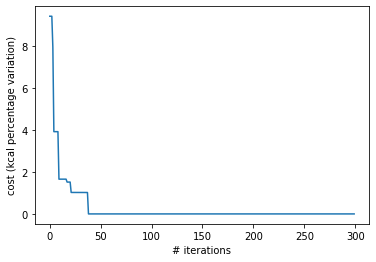

percentage variation: 0.0005386930893905628


In [ ]:
# Simulated Annealing
import time

def probability(p):
    return p > random.uniform(0.0, 1.0)

def exp_schedule(k=20, lam=0.005, limit=100):
    return lambda t: (k * np.exp(-lam * t) if t < limit else 0)


def SA(k, lam, limit):
    startTime = time.time()
    endTime = time.time()
    schedule = exp_schedule(k,lam, limit)
    states = []
    num_of_iterations = 300
    current = POIs_random;
    random.shuffle(current)
    iterations_to_converge = 0
    for t in range(num_of_iterations):
        bar.update(1)
        T = schedule(t)
        # neighbours = list()
        # for _ in range(5):
        #     child = current[:]
        #     i = random.randint(0, len(child) - 1)
        #     j = random.randint(0, len(child) - 1)
        #     child[i], child[j] = child[j], child[i]
        #     neighbours.append(child)
        child = current[:]
        i = random.randint(0, len(child) - 1)
        j = random.randint(0, len(child) - 1)
        child[i], child[j] = child[j], child[i]
        next_choice = child

        current_cost = abs(calculate_tsp_route_cost(current))
        next_cost = abs(calculate_tsp_route_cost(next_choice))
        delta_e = next_cost - current_cost  # difference of cost
        if delta_e < 0 or probability(np.exp(-1 * delta_e)/T): # getting closer to the goal
            current = next_choice
            states.append(next_cost)
            if(delta_e != 0):
                iterations_to_converge = t
                endTime = time.time()
        else:
            states.append(current_cost)
    time_to_converge = endTime - startTime

    return states, current, time_to_converge, states[-1]

# Parameter tuning and performance evaluation
k_candidate_values = [1, 5, 10, 15, 20, 25, 30, 35]
lam_candidate_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.015, 0.02]
limit_candidate_values = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
# lists to store info for each param value combination
lowest_cost_list_global = []
time_to_converge_list_global = []
cost_sequence_list_global = []
parameter_combo_list_global = []
poi_optimum_permutation_global_list = []
# try different param value combinations
for k in k_candidate_values:
  for lam in lam_candidate_values:
    for limit in limit_candidate_values:
      time_to_converge_list = []
      lowest_cost_list = []
      cost_sequence_list = [] # a cost sequence is a list of cost at each iteration, which can be used to plot cost vs iteration chart
      poi_optimum_permutation_list = []
      # run algorithm 3 times for each param value combination
      for i in range(3):
        cost_sequence, poi_permutation, time_to_converge, cost = SA(k, lam, limit)
        time_to_converge_list.append(time_to_converge) # refer to Xiaoyang's code to see how to measure time to converge
        lowest_cost_list.append(cost)
        cost_sequence_list.append(cost_sequence)
        poi_optimum_permutation_list.append(poi_permutation)
      
      # get index of lowest value in lowest_cost_list
      _, index = min((val, idx) for (idx, val) in enumerate(lowest_cost_list))
      parameter_combo_list_global.append({"k": k, "lam": lam, "limit":limit})
      lowest_cost_list_global.append(lowest_cost_list[index])
      time_to_converge_list_global.append(time_to_converge_list[index])
      cost_sequence_list_global.append(cost_sequence_list[index])
      poi_optimum_permutation_global_list.append(poi_optimum_permutation_list[index])

# Best parameter:
_, index = min((val, idx) for (idx, val) in enumerate(lowest_cost_list_global))
print("Best parameter combination: " + str(parameter_combo_list_global[index]))
print("Time to converge: " + str(time_to_converge_list_global[index]))
plot_graph("# iterations", "cost (kcal percentage variation)", cost_sequence_list_global[index])
print("percentage variation: " + str(lowest_cost_list_global[index]))
optimum_permutation = [origin_node_id] + poi_optimum_permutation_global_list[index] + [origin_node_id]
routes = []
for i in range(len(optimum_permutation)-1):
  local_poi_route = poi_route[optimum_permutation[i]][optimum_permutation[i+1]][:-1]
  routes.append(local_poi_route)


In [ ]:
# plot routes
m = draw_animated_routes(origin_corrdinates, 12, routes, poi_optimum_permutation_global_list[index], G);
m.save('SA.html')
m

In [ ]:
print(parameter_combo_list_global)
print(lowest_cost_list_global)
print(time_to_converge_list_global)
print(poi_optimum_permutation_global_list)
print(cost_sequence_list_global)

# Function to perform Partially Mapped Crossover (PMX)

In [ ]:
import numpy as np

def crossover(parent1, parent2):

    firstCrossPoint = np.random.randint(0,len(parent1)-2)
    secondCrossPoint = np.random.randint(firstCrossPoint+1,len(parent1)-1)

    #print(firstCrossPoint, secondCrossPoint)

    parent1MiddleCross = parent1[firstCrossPoint:secondCrossPoint]
    parent2MiddleCross = parent2[firstCrossPoint:secondCrossPoint]

    temp_child1 = parent1[:firstCrossPoint] + parent2MiddleCross + parent1[secondCrossPoint:]

    temp_child2 = parent2[:firstCrossPoint] + parent1MiddleCross + parent2[secondCrossPoint:]

    relations = []
    for i in range(len(parent1MiddleCross)):
        relations.append([parent2MiddleCross[i], parent1MiddleCross[i]])

    #print(relations)

    def recursion1 (temp_child , firstCrossPoint , secondCrossPoint , parent1MiddleCross , parent2MiddleCross) :
        child = np.array([0 for i in range(len(parent1))])
        for i,j in enumerate(temp_child[:firstCrossPoint]):
            c=0
            for x in relations:
                if j == x[0]:
                    child[i]=x[1]
                    c=1
                    break
            if c==0:
                child[i]=j
        j=0
        for i in range(firstCrossPoint,secondCrossPoint):
            child[i]=parent2MiddleCross[j]
            j+=1

        for i,j in enumerate(temp_child[secondCrossPoint:]):
            c=0
            for x in relations:
                if j == x[0]:
                    child[i+secondCrossPoint]=x[1]
                    c=1
                    break
            if c==0:
                child[i+secondCrossPoint]=j
        child_unique=np.unique(child)
        if len(child)>len(child_unique):
            child=recursion1(child,firstCrossPoint,secondCrossPoint,parent1MiddleCross,parent2MiddleCross)
        return(child)

    def recursion2(temp_child,firstCrossPoint,secondCrossPoint,parent1MiddleCross,parent2MiddleCross):
        child = np.array([0 for i in range(len(parent1))])
        for i,j in enumerate(temp_child[:firstCrossPoint]):
            c=0
            for x in relations:
                if j == x[1]:
                    child[i]=x[0]
                    c=1
                    break
            if c==0:
                child[i]=j
        j=0
        for i in range(firstCrossPoint,secondCrossPoint):
            child[i]=parent1MiddleCross[j]
            j+=1

        for i,j in enumerate(temp_child[secondCrossPoint:]):
            c=0
            for x in relations:
                if j == x[1]:
                    child[i+secondCrossPoint]=x[0]
                    c=1
                    break
            if c==0:
                child[i+secondCrossPoint]=j
        child_unique=np.unique(child)
        if len(child)>len(child_unique):
            child=recursion2(child,firstCrossPoint,secondCrossPoint,parent1MiddleCross,parent2MiddleCross)
        return(child)

    child1=list(recursion1(temp_child1,firstCrossPoint,secondCrossPoint,parent1MiddleCross,parent2MiddleCross))
    child2=list(recursion2(temp_child2,firstCrossPoint,secondCrossPoint,parent1MiddleCross,parent2MiddleCross))

    #print(child1)
    #print(child2)

    return (child1,child2)

    #Source: https://stackoverflow.com/questions/53254449/how-to-perform-partial-mapped-crossover-in-python3

    

# Particle Swarm Optimization (PSO) to solve TSP

In [ ]:
from itertools import product
from random import choice
import random
from time import time
from tqdm.notebook import tqdm

# Parameters for PSO
particles_swarm_candidates = [100, 200, 400]
num_of_swarms_candidates = [2, 4, 10]
num_of_iterations = 300
convergence_threshold = 0.0001 # if change smaller than 0.01% then converge

# Lists to store info for each param combo
lowest_cost_list_pso = []
time_to_converge_list_pso = []
cost_sequence_list_pso = []
parameter_combo_list_pso = []
poi_optimum_permutation_list_pso = []

# Find best param combo for PSO
for particles_swarm in particles_swarm_candidates:
  # A particle is a permutaion of all POIs (excluding origin)
  particles = []
  for _ in range(particles_swarm):
    particles.append(random.sample(POIs_random, len(POIs_random)))
  
  for num_of_swarms in num_of_swarms_candidates:
    time_to_converge_list = []
    lowest_cost_list = []
    cost_sequence_list = []
    poi_optimum_permutation_list = []

    # Run algorithm 3 times for each param combo to reduce effects of randomness
    for t in range(3):
      cost_sequence = []
      poi_optimum_permutation = []
      lowest_cost = math.inf
      prev_cost = -200.0
      has_converged = False
      convergence_time = 0
      t0 = time()

      print('')
      print('particles_swarm: ', particles_swarm)
      print('num_of_swarms: ', num_of_swarms)
      print('time: ', t+1, 'out of 3')
      pbar = tqdm(total = num_of_iterations)

      for iteration in range(num_of_iterations):
          pbar.update(1)
          
          # we need to have `num_of_swarms` particles to lead
          # a swarm and be its lbest ... that changes every iteration
          particles.sort(key = lambda particle : abs(calculate_tsp_route_cost(particle)))

          c = calculate_tsp_route_cost(particles[0])
          cost_sequence.append(c)
          if (c < lowest_cost):
            lowest_cost = c
            poi_optimum_permutation = particles[0]
          if (not has_converged and abs(c-prev_cost)/abs(prev_cost) <= convergence_threshold): 
            has_converged = True
            convergence_time = time() - t0
          if (abs(c-prev_cost)/abs(prev_cost) > convergence_threshold):
            has_converged = False
          prev_cost = c

          swarm_particles = particles_swarm // num_of_swarms
          
          leaders = particles[:swarm_particles][:]
          
          for i in range(num_of_swarms): 
              particles[i] , particles[i * (swarm_particles) - 1] = particles[i * (swarm_particles) - 1], particles[i]
          
          swarms = list()
          
          for i in range(num_of_swarms):
              swarms.append(particles[i * (swarm_particles): i*(swarm_particles) + swarm_particles])
          
          # for each swarm follow the leader of the swarm
          def follow_leader_local(population):
              for i in range(1, len(population)):
                  population[i] = crossover(population[0], population[i])[0] # this is what we are doing
                  
          for swarm in swarms:
              follow_leader_local(swarm)
          
          def follow_leader_global():
              for u, v in product(range(0, len(leaders)), range(0, len(leaders))):
                  tobeMutated = choice([u, v])
                  leaders[tobeMutated] = crossover(leaders[u], leaders[v])[0]
                  
          follow_leader_global()
          
          # adding the new leaders
          
          for i in range(num_of_swarms):
              particles[i*(swarm_particles - 1)] = leaders[i]

      pbar.close()

      if not has_converged:
        convergence_time = time() - t0
      print("converge time: " + str(convergence_time))
      print("cost: " + str(lowest_cost))
      lowest_cost_list.append(lowest_cost)
      time_to_converge_list.append(convergence_time)
      cost_sequence_list.append(cost_sequence)
      poi_optimum_permutation_list.append(poi_optimum_permutation)

    _, index = min((val, idx) for (idx, val) in enumerate(lowest_cost_list))
    lowest_cost_list_pso.append(lowest_cost_list[index])
    time_to_converge_list_pso.append(time_to_converge_list[index])
    cost_sequence_list_pso.append(cost_sequence_list[index])
    poi_optimum_permutation_list_pso.append(poi_optimum_permutation_list[index])
    parameter_combo_list_pso.append({"particles_swarm": particles_swarm,\
                                     "num_of_swarms": num_of_swarms})



particles_swarm:  100
num_of_swarms:  2
time:  1 out of 3



converge time: 38.480366468429565
cost: 0.0013764585648118554

particles_swarm:  100
num_of_swarms:  2
time:  2 out of 3



converge time: 0.20639562606811523
cost: 0.0013764585648118554

particles_swarm:  100
num_of_swarms:  2
time:  3 out of 3



converge time: 0.20022964477539062
cost: 0.0013764585648118554

particles_swarm:  100
num_of_swarms:  4
time:  1 out of 3



converge time: 9.154075145721436
cost: 0.0005386930893905628

particles_swarm:  100
num_of_swarms:  4
time:  2 out of 3



converge time: 0.09341764450073242
cost: 0.0005386930893905628

particles_swarm:  100
num_of_swarms:  4
time:  3 out of 3



converge time: 0.09277200698852539
cost: 0.0005386930893905628

particles_swarm:  100
num_of_swarms:  10
time:  1 out of 3



converge time: 0.060606956481933594
cost: 0.0005386930893905628

particles_swarm:  100
num_of_swarms:  10
time:  2 out of 3



converge time: 0.05623507499694824
cost: 0.0005386930893905628

particles_swarm:  100
num_of_swarms:  10
time:  3 out of 3



converge time: 0.04566812515258789
cost: 0.0005386930893905628

particles_swarm:  200
num_of_swarms:  2
time:  1 out of 3



converge time: 52.864134788513184
cost: 0.018465026140540887

particles_swarm:  200
num_of_swarms:  2
time:  2 out of 3



converge time: 148.29613780975342
cost: 0.00890335871501975

particles_swarm:  200
num_of_swarms:  2
time:  3 out of 3



converge time: 0.614903450012207
cost: 0.00890335871501975

particles_swarm:  200
num_of_swarms:  4
time:  1 out of 3



converge time: 40.76021671295166
cost: 0.0057342221787848755

particles_swarm:  200
num_of_swarms:  4
time:  2 out of 3



converge time: 0.2134230136871338
cost: 0.0057342221787848755

particles_swarm:  200
num_of_swarms:  4
time:  3 out of 3



converge time: 37.07095909118652
cost: 0.005315948706379458

particles_swarm:  200
num_of_swarms:  10
time:  1 out of 3



converge time: 0.09682321548461914
cost: 0.005315948706379458

particles_swarm:  200
num_of_swarms:  10
time:  2 out of 3



converge time: 0.08736681938171387
cost: 0.005315948706379458

particles_swarm:  200
num_of_swarms:  10
time:  3 out of 3



converge time: 0.09188294410705566
cost: 0.005315948706379458

particles_swarm:  400
num_of_swarms:  2
time:  1 out of 3



converge time: 2.2118570804595947
cost: 0.03554281993071982

particles_swarm:  400
num_of_swarms:  2
time:  2 out of 3



converge time: 2.366346597671509
cost: 0.03554281993071982

particles_swarm:  400
num_of_swarms:  2
time:  3 out of 3



converge time: 147.1641788482666
cost: 0.029479012422063987

particles_swarm:  400
num_of_swarms:  4
time:  1 out of 3



converge time: 101.95865368843079
cost: 0.0014599699993368632

particles_swarm:  400
num_of_swarms:  4
time:  2 out of 3



converge time: 0.6503026485443115
cost: 0.0014599699993368632

particles_swarm:  400
num_of_swarms:  4
time:  3 out of 3



converge time: 0.6811316013336182
cost: 0.0014599699993368632

particles_swarm:  400
num_of_swarms:  10
time:  1 out of 3



converge time: 0.18225884437561035
cost: 0.0014599699993368632

particles_swarm:  400
num_of_swarms:  10
time:  2 out of 3



converge time: 0.20014405250549316
cost: 0.0014599699993368632

particles_swarm:  400
num_of_swarms:  10
time:  3 out of 3


In [ ]:
print(parameter_combo_list_pso)
print(poi_optimum_permutation_list_pso)
print(cost_sequence_list_pso)
print(time_to_converge_list_pso)
print(lowest_cost_list_pso)

[{'particles_swarm': 100, 'num_of_swarms': 2}, {'particles_swarm': 100, 'num_of_swarms': 4}, {'particles_swarm': 100, 'num_of_swarms': 10}, {'particles_swarm': 200, 'num_of_swarms': 2}, {'particles_swarm': 200, 'num_of_swarms': 4}, {'particles_swarm': 200, 'num_of_swarms': 10}, {'particles_swarm': 400, 'num_of_swarms': 2}, {'particles_swarm': 400, 'num_of_swarms': 4}, {'particles_swarm': 400, 'num_of_swarms': 10}]
[[1080142009, 4615934052, 2293818490, 5492699165, 1080147418, 431511941, 708668639, 431512052], [1080147418, 5492699165, 4615934052, 2293818490, 431512052, 431511941, 708668639, 1080142009], [1080147418, 5492699165, 4615934052, 2293818490, 431512052, 431511941, 708668639, 1080142009], [431511941, 5492699165, 4615934052, 431512052, 2293818490, 1080142009, 1080147418, 708668639], [4615934052, 431512052, 2293818490, 1080142009, 5492699165, 431511941, 708668639, 1080147418], [4615934052, 431512052, 2293818490, 1080142009, 5492699165, 431511941, 708668639, 1080147418], [4615934052

In [ ]:
# get best param combo

_, index = min((val, idx) for (idx, val) in enumerate(lowest_cost_list_pso))

lowest_cost_pso = lowest_cost_list_pso[index]
time_to_converge_pso = time_to_converge_list_pso[index]
cost_sequence_pso = cost_sequence_list_pso[index]
poi_optimum_permutation_pso = poi_optimum_permutation_list_pso[index]
parameter_combo_pso = parameter_combo_list_pso[index]

print('*** Best param combo: ')
print(parameter_combo_pso)
print('*** Lowest cost: ')
print(lowest_cost_pso)
print('*** Time to converge: ')
print(time_to_converge_pso)
print('*** Best POI permutation: ')
print(poi_optimum_permutation_pso)

In [ ]:
# plot cost vs iteration graph for best param combo
plot_graph("# iterations", "cost (kcal percentage variation)", cost_sequence_pso)

In [ ]:
# plot routes
routes = []
pso_perm = [origin_node_id] + poi_optimum_permutation_pso + [origin_node_id]
for i in range(len(pso_perm)-1):
  local_poi_route = poi_route[pso_perm[i]][pso_perm[i+1]][:-1]
  routes.append(local_poi_route)

m = draw_animated_routes(origin_corrdinates, 12, routes, poi_optimum_permutation_pso, G);
m.save('PSO.html')
m

# Firefly Optimization to solve TSP

In [ ]:
#Firefly

import osmnx as ox
#from utilities import *
from itertools import filterfalse
import time

#the original value of parameter from github
#num_of_flies = 25
#gamma = 2

def luminosity(route):
    return abs(calculate_tsp_route_cost(route)) + len(route)

# number of common nodes between two routes
def distance(route1, route2):
    return len(set(route1) & set(route2))

def firefly(gamma, num_of_flies):

    start_time = time.time() ## Records current time
    states = []

    num_of_iterations = 300
    flies = []
    pre_cost = -200
    con_flag = False
    for _ in range(num_of_iterations):
      flies.append(random.sample(POIs_random, len(POIs_random)))


    for _ in tqdm(range(num_of_iterations)):
        for i in range(num_of_flies):
            flies_luminosity = list() # for all flies except i
            for j in range(num_of_flies):
                if i == j: continue # skips getting luminosity of fly i
                flies_luminosity.append((j , luminosity(flies[j]))) # saving both the fly and its luminosity
            moving_fly = flies[i]
            # remember that the shortest path and the fewest number of nodes is more luminous for us
            # in this problem, hence using min function instead of max
            moving_to_fly = min(flies_luminosity, key = lambda fly : fly[1] * math.exp(-1 * gamma * distance(moving_fly, flies[fly[0]])))
            moving_to_fly = flies[moving_to_fly[0]]
            # updating
            flies[i] = crossover(moving_fly, moving_to_fly)[0]
        flies.sort(key = lambda flies : abs(calculate_tsp_route_cost(flies)))
        c = calculate_tsp_route_cost(flies[0])
        states.append(c)
        if abs(c-pre_cost)/abs(pre_cost) > 0.0001:
            con_flag = False
        if not con_flag and abs(c-pre_cost)/abs(pre_cost) <= 0.0001:
            end_time = time.time() ## Records current time
            con_flag = True
        pre_cost = c


    if con_flag == False:
        end_time = time.time() ## Records current time
    time_to_converge = abs(end_time - start_time)
    poi_permutation = min(flies, key = lambda fly : luminosity(fly))
    return states, poi_permutation, time_to_converge, states[-1]



# Parameter tuning and performance evaluation
gamma_candidate_values = [0, 1, 2, 3, 4]
flies_candidate_values = [15, 20, 25, 30, 35, 40]

# lists to store info for each param value combination
lowest_cost_list_global = []
time_to_converge_list_global = []
cost_sequence_list_global = []
parameter_combo_list_global = []
poi_optimum_permutation_global_list = []
# try different param value combinations
for ga in gamma_candidate_values:
  for fly in flies_candidate_values:
    time_to_converge_list = []
    lowest_cost_list = []
    cost_sequence_list = [] # a cost sequence is a list of cost at each iteration, which can be used to plot cost vs iteration chart
    poi_optimum_permutation_list = []
    # run algorithm 3 times for each param value combination
    for i in range(3):
      cost_sequence, poi_permutation, time_to_converge, cost = firefly(ga, fly)
      time_to_converge_list.append(time_to_converge) # refer to Xiaoyang's code to see how to measure time to converge
      lowest_cost_list.append(cost)
      cost_sequence_list.append(cost_sequence)
      poi_optimum_permutation_list.append(poi_permutation)
    
    # get index of lowest value in lowest_cost_list
    _, index = min((val, idx) for (idx, val) in enumerate(lowest_cost_list))
    parameter_combo_list_global.append({"gamma": ga, "flies": fly})
    lowest_cost_list_global.append(lowest_cost_list[index])
    time_to_converge_list_global.append(time_to_converge_list[index])
    cost_sequence_list_global.append(cost_sequence_list[index])
    poi_optimum_permutation_global_list.append(poi_optimum_permutation_list[index])

# Best parameter:
_, index = min((val, idx) for (idx, val) in enumerate(lowest_cost_list_global))
print("Best parameter combination: " + str(parameter_combo_list_global[index]))
print("Time to converge: " + str(time_to_converge_list_global[index]))
plot_graph("# iterations", "cost (kcal percentage variation)", cost_sequence_list_global[index])
print("percentage variation: " + str(lowest_cost_list_global[index]))
optimum_permutation = [origin_node_id] + poi_optimum_permutation_global_list[index] + [origin_node_id]
routes = []
for i in range(len(optimum_permutation)-1):
  local_poi_route = poi_route[optimum_permutation[i]][optimum_permutation[i+1]][:-1]
  routes.append(local_poi_route)

In [ ]:
# plot routes
m = draw_animated_routes(origin_corrdinates, 12, routes, poi_optimum_permutation_global_list[index], G);
m.save('FireFly.html')
m

In [ ]:
print(lowest_cost_list_global)
print(time_to_converge_list_global)
print(cost_sequence_list_global)
print(parameter_combo_list_global)
print(poi_optimum_permutation_global_list)

# A* to find fittest route between each pair of POIs (kept for reference)

In [ ]:
# class A_star_Node:
#     # using __slots__ for optimization
#     __slots__ = ['node', 'distance', 'parent', 'osmid', 'G','g','h','f']
#     # constructor for each node
#     def __init__(self ,graph , osmid, distance = 0, parent = None,g=0,h=0):
#         # the dictionary of each node as in networkx graph --- still needed for internal usage
#         self.node = graph[osmid]
        
#         # the distance from the parent node --- edge length
#         self.distance = distance
        
#         # the parent node
#         self.parent = parent
        
#         # unique identifier for each node so we don't use the dictionary returned from osmnx
#         self.osmid = osmid
        
#         # the graph
#         self.G = graph

#         #for cost f = g + h
#         # g(n) — this represents the exact cost of the path from the starting node to any node n
#         # h(n) — this represents the heuristic estimated cost from node n to the goal node.
#         # f(n) — lowest cost in the neighboring node n
#         self.g = 0
#         self.h = 0
#         self.f = self.g + self.h

#     def get_mahanttan_dist(self, dest):
#         return abs(self.G.nodes[self.osmid]['x'] - dest['x']) + abs(self.G.nodes[self.osmid]['y'] - dest['y'])

#     # returning all the nodes adjacent to the node
#     def expand(self,dest):
#         children = [Node(graph = self.G, osmid = child, distance = self.node[child][0]['length'], parent = self, g = self.node[child][0]['length'], h = self.get_mahanttan_dist(dest)) \
#                         for child in self.node]
#         return children
    
    
#     # returns the path from that node to the origin as a list and the length of that path
#     def path(self):
#         node = self
#         path = []
#         while node:
#             path.append(node.osmid)
#             node = node.parent
#         return path[::-1]
    
#     # the following two methods are for dictating how comparison works

#     def __eq__(self, other):
#         try:
#             return self.osmid == other.osmid
#         except:
#             return self.osmid == other
            
    
#     def __hash__(self):
#         return hash(self.osmid)

#     # Sort nodes
#     def __lt__(self, other):
#          return self.f < other.f






# # Check if a neighbor should be added to open list
# def add_to_open(open, neighbor):
#     for node in open:
#         if (neighbor == node and neighbor.f > node.f):
#             return False
#     return True


# # Find fittest route between each pair of POIs using A*

# import time, math
# from collections import deque
# from tqdm import tqdm


# origin_corrdinates = getOriginCorrdinates(G, ORIGIN_ADDR)

# origin_node_id = ox.get_nearest_node(G, origin_corrdinates)

# POIs_random = getListOfPOIs(G, number_of_pois_to_travel, origin_node_id, origin_corrdinates, search_radius, LIST_OF_POI_TAGS)
# dest_node_id = POIs_random[0]

# origin = A_star_Node(graph = G, osmid = origin_node_id)

# destination = A_star_Node(graph = G, osmid = dest_node_id)

# bar = tqdm(total = len(G))

# # we will be dealing with the id of the nodes of the graph in our lists
# # except for unrelaxed_node list where we need to have an actual `Node` object
# # so we can invoke the path() function on it when we arrive at destination

# seen = set()         # for dealing with self loops

# shortest_dist = {osmid: math.inf for osmid in G.nodes()}
# unrelaxed_nodes = [A_star_Node(graph = G, osmid = osmid) for osmid in G.nodes()]

# shortest_dist[origin.osmid] = 0
# found = False


# open = []
# closed = []
# open.append(origin)

# # Loop until the open list is empty
# while len(open) > 0:
#     # Sort the open list to get the node with the lowest cost first
#     open.sort()
#     # Get the node with the lowest cost
#     current_node = open.pop(0)
#     # Add the current node to the closed list
#     closed.append(current_node)
#     # Check if we have reached the goal, return the path
#     if current_node == destination:
#         path = []
#         while current_node != origin:
#             path.append(current_node.osmid)
#             current_node = current_node.parent
#         path.append(origin.osmid)
#         # Return reversed path
#         res = path[::-1]
    
#     # otherwise, let's relax edges of its neighbours
#     for child in current_node.expand(G.nodes[dest_node_id]):
#         if child.osmid in closed: continue
#         child.g = current_node.g + child.distance
#         child.h = child.get_mahanttan_dist(G.nodes[dest_node_id])
#         child.f = child.g + child.h
#         # Check if neighbor is in open list and if it has a lower f value
#         if(add_to_open(open, child) == True):
#             # Everything is green, add neighbor to open list
#             open.append(child)
#     # Return None, no path is found
# print(res)    

